# Training Data Evaluation


In [73]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting, reduction
import pandas
from enum import Enum
import scipy.spatial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.tree import export_graphviz
import pydot
import pickle
from joblib import dump, load
import os.path

%load_ext autoreload
%autoreload 2
%matplotlib inline

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
class SubmapState(Enum):
    ALL_GOOD = 1
    LOCAL_GOOD = 2
    NO_GOOD = 3

class WaveletEvaluator(object):

    def __init__(self, n_scales = 7):
        self.n_scales = n_scales

    def set_scales(self, n_scales):
        self.n_scales = n_scales

    def compare_signals(self, G, x_1, x_2):

        # Compute the wavelets for each node and scale.
        psi = self.compute_wavelets(G)
        print(f"[WaveletEvaluator] psi = {psi.shape}")

        # Compute the wavelet coefficients for x_1 and x_2.
        W_1 = self.compute_wavelet_coefficients(psi, x_1)
        W_2 = self.compute_wavelet_coefficients(psi, x_2)
        print(f"[WaveletEvaluator] W_1 = {W_1.shape}")
        print(f"[WaveletEvaluator] W_2 = {W_2.shape}")


    def compute_wavelets(self, G):
        print(f"[WaveletEvaluator] Computing wavelets for {self.n_scales}")
        g = filters.Meyer(G, self.n_scales)

        # Evalute filter bank on the frequencies (eigenvalues).
        f = g.evaluate(G.e)
        f = np.expand_dims(f.T, 1)
        psi = np.zeros((G.N, G.N, self.n_scales))

        for i in range(0, G.N):

            # Create a Dirac centered at node i.
            x = np.zeros((G.N,1))
            x[i] = 1

            # Transform the signal to spectral domain.
            s = G._check_signal(x)
            s = G.gft(s)

            # Multiply the transformed signal with filter.
            if s.ndim == 1:
                s = np.expand_dims(s, -1)
            s = np.expand_dims(s, 1)
            s = np.matmul(s, f)

            # Transform back the features to the vertex domain.
            psi[i, :, :] = G.igft(s).squeeze()

        return psi

    def compute_wavelets_coeffs(self, wavelet, x_signal):
        n_values = x_signal.shape[0]
        W = np.zeros((n_values, self.n_scales))
        for i in range(0, n_values):
            for j in range(0, self.n_scales):
                W[i,j] = np.matmul(wavelet[i,:,j].transpose(), x_signal)

        return W

    def check_submap(self, coeffs_1, coeffs_2, submap_ids):
        submap_coeffs_1 = coeffs_1[submap_ids, :]
        submap_coeffs_2 = coeffs_2[submap_ids, :]

        D = self.compute_generic_distance(submap_coeffs_1, submap_coeffs_2)
        #D = self.compute_cosine_distance(submap_coeffs_1, submap_coeffs_2)
        #print(f"dist: {D.transpose()}")
        return self.evaluate_scales(D)
    
    def compute_features_for_submap(self, coeffs_1, coeffs_2, submap_ids):
        submap_coeffs_1 = coeffs_1[submap_ids, :]
        submap_coeffs_2 = coeffs_2[submap_ids, :]
        
        D = self.compute_distances(submap_coeffs_1, submap_coeffs_2)
                              
        data = np.array([            
            # Euclidean distance.
            np.sum(D[0, 0:2]),
            np.sum(D[0, 2:4]),
            np.sum(D[0, 5:]),            
            
            # Correlation.
            np.sum(D[1, 0:2]),
            np.sum(D[1, 2:4]),
            np.sum(D[1, 5:]),                        
            
            # Cityblock distance.
            np.sum(D[2, 0:2]),
            np.sum(D[2, 2:4]),
            np.sum(D[2, 5:]),
            
            # Chebyshev distance.
            np.sum(D[3, 0:2]),
            np.sum(D[3, 2:4]),
            np.sum(D[3, 5:]),            
        ])
        
        return data
        

    def compute_cosine_distance(self, coeffs_1, coeffs_2):
        #print(f"c1 {coeffs_1.shape} and c2 {coeffs_2.shape}")
        cosine_distance = np.zeros((self.n_scales, 1))
        for j in range(0, self.n_scales):
            cross = np.dot(coeffs_1[:,j], coeffs_2[:,j])
            n_1 = np.linalg.norm(coeffs_1[:,j])
            n_2 = np.linalg.norm(coeffs_2[:,j])


            cosine_similarity = cross/(n_1*n_2)
            cosine_distance[j] = 1 - cosine_similarity
        return cosine_distance
    
    def compute_distances(self, coeffs_1, coeffs_2):
        distances = np.zeros((9, self.n_scales))            
        for j in range(0, self.n_scales):                              
            distances[0, j] = scipy.spatial.distance.euclidean(coeffs_1[:,j], coeffs_2[:,j])            
            distances[1, j] = scipy.spatial.distance.correlation(coeffs_1[:,j], coeffs_2[:,j])
            distances[2, j] = scipy.spatial.distance.cityblock(coeffs_1[:,j], coeffs_2[:,j])         
            distances[3, j] = scipy.spatial.distance.chebyshev(coeffs_1[:,j], coeffs_2[:,j])
            
        return distances

    def evaluate_scales(self, D):
        k_eps = 0.3
        
        sum_lower = np.sum(D[0:2])
        print(f"Lower sum resulting in {sum_lower.transpose()}")
        
        sum_band = np.sum(D[2:4])
        print(f"Band sum resulting in {sum_band.transpose()}")
        
        sum_higher = np.sum(D[5:])
        print(f"Higher sum resulting in {sum_higher.transpose()}")
        sum_total = sum_lower + sum_higher
        print(f"--------------------")

        if (sum_total < k_eps):
            return SubmapState.ALL_GOOD
        elif (sum_lower < k_eps and sum_higher >= k_eps):
            return SubmapState.LOW_GOOD
        elif (sum_lower >= k_eps and sum_higher < k_eps):
            return SubmapState.HIGH_GOOD
        else:
            return SubmapState.NO_GOOD


## Load Input from File

In [78]:
dataroot = '/mnt/data/datasets/fgsp/'
datasets = ['gonzen_mission_03_cerberus/']

n_datasets = len(datasets)
opt_signals = []
est_signals = []
opt_trajectory = []
est_trajectory = []
opt_graph_coords = []
opt_graph_adj = []
for ds in datasets:
    ds_path = dataroot + ds
    print(f'Loading data from {ds_path}')
    opt_signal_path = ds_path + 'opt_signal.npy'
    opt_traj_path = ds_path + 'opt_trajectory.npy'
    est_signal_path = ds_path + 'est_signal.npy'
    est_traj_path = ds_path + 'est_trajectory.npy'  
    opt_graph_coords_path = ds_path + 'opt_graph_coords.npy'
    opt_graph_adj_path = ds_path + 'opt_graph_adj.npy'
 
    if os.path.isfile(opt_signal_path) and os.path.isfile(est_signal_path):
        opt_signals.append(np.load(opt_signal_path))
        est_signals.append(np.load(est_signal_path))
        
    if os.path.isfile(opt_traj_path) and os.path.isfile(est_traj_path):
        opt_trajectory.append(np.load(opt_traj_path))
        est_trajectory.append(np.load(est_traj_path))
    
    if os.path.isfile(opt_graph_coords_path) and os.path.isfile(opt_graph_adj_path):
        opt_graph_coords.append(np.load(opt_graph_coords_path))
        opt_graph_adj.append(np.load(opt_graph_adj_path))
    
    
print(f'=======================================')
n_datasets = len(opt_signals)
n_trajectories = len(opt_trajectory)
assert n_datasets == len(est_signals)
assert n_trajectories == len(opt_trajectory)
print(f'Finished loading {n_datasets} datasets and {n_trajectories} trajectories.')

Loading data from /mnt/data/datasets/fgsp/gonzen_mission_03_cerberus/
Finished loading 1 datasets and 1 trajectories.


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f7ebe919b00>)

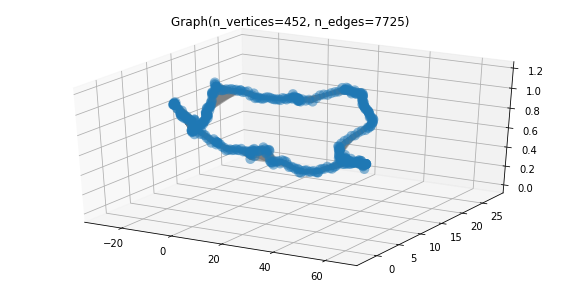

In [80]:
graph_per_dataset = []
for i in range(0, n_datasets):
    G = graphs.Graph(opt_graph_adj[i])
    G.set_coordinates(opt_graph_coords[i])
    G.compute_fourier_basis()
    graph_per_dataset.append(G)

graph_per_dataset[0].plot()

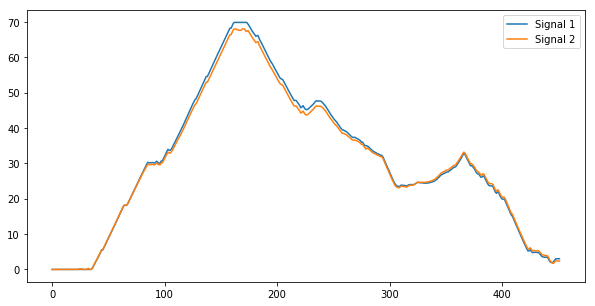

Signal shapes are (452,) and (452,)


In [98]:
def compare_signals(signal_1, signal_2):
    plt.plot(signal_1, label='Signal 1')
    plt.plot(signal_2, label='Signal 2')
    plt.legend()
    plt.show()

i = 0
compare_signals(est_signals[i], opt_signals[i])
print(f'Signal shapes are {est_signals[i].shape} and {opt_signals[i].shape}')

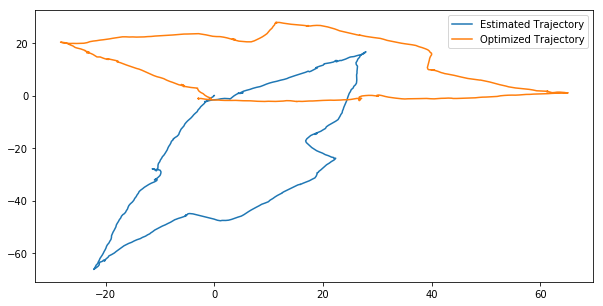

Signal shapes are (452, 3) and (452, 3)


In [82]:
def compare_trajectories(est_traj, opt_traj):    
    plt.plot(est_traj[:,0], est_traj[:,1], label='Estimated Trajectory')
    plt.plot(opt_traj[:,0], opt_traj[:,1], label='Optimized Trajectory')
    plt.legend()
    plt.show()
    
i = 0
compare_trajectories(est_trajectory[i], opt_trajectory[i])
print(f'Signal shapes are {est_trajectory[i].shape} and {opt_trajectory[i].shape}')

----------------------------------------
## Learn a Random Forest Classifier

In [130]:
all_data = pandas.DataFrame([])
feature_names = ['Euclidean_L',
                 'Euclidean_B',
                 'Euclidean_H',
                 'Correlation_L',
                 'Correlation_B',
                 'Correlation_H',                 
                 'Manhattan_L',
                 'Manhattan_B',
                 'Manhattan_H',
                 'Chebyshev_L',
                 'Chebyshev_B',
                 'Chebyshev_H']

## Position-based Difference

In [138]:
def compute_labels_for_signals(est_signal, opt_signal, submap_indices):    
    n_est_signal = len(est_signal)
    n_opt_signal = len(opt_signal)        
    assert n_est_signal == n_opt_signal
    for i in submap_indices:
        diff = np.abs(est_signal[i] - opt_signal[i])
        if diff > 1:
            return 1
        
    return 0    

labels = {}
for ds_idx in range(0, n_datasets):
    # Compute wavelets.
    eval = WaveletEvaluator()
    psi = eval.compute_wavelets(graph_per_dataset[ds_idx])
    print(f" psi = {psi.shape}")
    
    W_1 = eval.compute_wavelets_coeffs(psi, est_signals[ds_idx])
    W_2 = eval.compute_wavelets_coeffs(psi, opt_signals[ds_idx])
    
    n_submaps = 40
    submap_size = int(G.N/n_submaps)
    indices = []
    submap_indices = []
    state_signal = np.zeros((G.N, 1))

    submap_data = []
    submap_labels = []
    for i in range(0, G.N):
        n_indices_in_submap = len(submap_indices)

        # If the submap reached max size, evaluate it.
        if n_indices_in_submap > 0 and n_indices_in_submap % submap_size == 0:        
            features = eval.compute_features_for_submap(W_1, W_2, submap_indices)
            label = compute_labels_for_signals(est_signals[ds_idx], opt_signals[ds_idx], submap_indices)
            
            submap_data.append(features)
            submap_labels.append(label)
            submap_indices = []

        submap_indices.append(i)
    
    submap_data = np.array(submap_data)
    submap_labels = np.array(submap_labels)    
    print(f'labels {submap_labels.shape} and submap_data {submap_data.shape}')
    data=pandas.DataFrame({
        feature_names[0]:submap_data[:,0],
        feature_names[1]:submap_data[:,1],
        feature_names[2]:submap_data[:,2],

        feature_names[3]:submap_data[:,3],
        feature_names[4]:submap_data[:,4],
        feature_names[5]:submap_data[:,5],

        feature_names[6]:submap_data[:,6],
        feature_names[7]:submap_data[:,7],
        feature_names[8]:submap_data[:,8],

        feature_names[9]:submap_data[:,9],
        feature_names[10]:submap_data[:,10],
        feature_names[11]:submap_data[:,11],
        
        'state':submap_labels
    })

    all_data=all_data.append(data)

[WaveletEvaluator] Computing wavelets for 7
 psi = (452, 452, 7)
labels (41,) and submap_data (41, 12)


In [146]:
print(f"Size of all_data = {all_data.shape[0]}")
all_data.tail()

Size of all_data = 123


,Euclidean_L,Euclidean_B,Euclidean_H,Correlation_L,Correlation_B,Correlation_H,Manhattan_L,Manhattan_B,Manhattan_H,Chebyshev_L,Chebyshev_B,Chebyshev_H,state
36,2.195811,0.070057,0.000059,0.011609,0.117267,0.000042,7.120629,0.178154,0.000153,0.780387,0.042218,0.000044,0
37,2.819803,0.521106,0.000013,0.000646,0.005177,0.000386,9.090143,1.283092,0.000030,1.027477,0.363473,0.000009,0
38,1.966559,0.800449,0.000804,0.000949,0.005916,0.000918,6.337687,2.390330,0.002023,0.863782,0.397562,0.000485,0
39,1.142216,1.125657,0.002012,0.000018,0.020342,0.056967,3.627584,3.189755,0.004729,0.423242,0.545278,0.001569,0
40,0.576908,1.104358,0.049576,0.008186,0.147512,0.050038,1.834771,3.028497,0.087787,0.234504,0.558642,0.040434,0


In [147]:
all_data = all_data.fillna(0)
all_data = all_data.replace(float('inf'), 1)

# without JSD
#feature_names = ['Cosine_L', 'Cosine_B', 'Cosine_H','Euclidean_L', 'Euclidean_B', 'Euclidean_H','BrayCurtis_L', 'BrayCurtis_B', 'BrayCurtis_H','Correlation_L', 'Correlation_B', 'Correlation_H', 'Canberra_L', 'Canberra_B', 'Canberra_H', 'Minkowski_L', 'Minkowski_B', 'Minkowski_H', 'Manhattan_L', 'Manhattan_B', 'Manhattan_H', 'Chebyshev_L', 'Chebyshev_B', 'Chebyshev_H']

# Full
feature_names = ['Euclidean_L', 'Euclidean_B', 'Euclidean_H','Correlation_L', 'Correlation_B', 'Correlation_H', 'Manhattan_L', 'Manhattan_B', 'Manhattan_H', 'Chebyshev_L', 'Chebyshev_B', 'Chebyshev_H']


In [148]:
X=all_data[feature_names]
y=all_data['state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

dump(clf, '../config/forest.joblib') 
#clf = load('filename.joblib') 

['../config/forest.joblib']

In [149]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7837837837837838


No handles with labels found to put in legend.


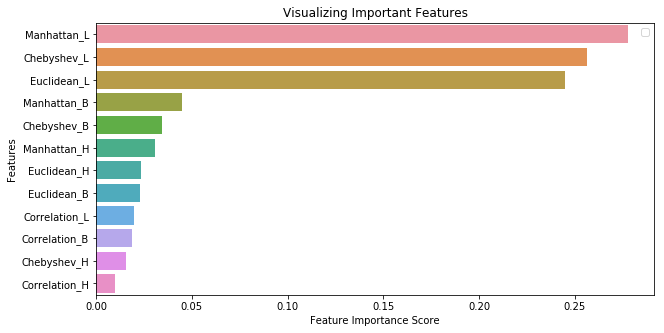

In [137]:
feature_imp = pandas.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()


In [240]:
# Pull out one tree from the forest
tree = clf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_names, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

## Real Tests

In [7]:
clf = load('../config/forest.joblib') 

In [ ]:
feature_names = ['Cosine_L', 'Cosine_B', 'Cosine_H','Euclidean_L', 'Euclidean_B', 'Euclidean_H','BrayCurtis_L', 'BrayCurtis_B', 'BrayCurtis_H','Correlation_L', 'Correlation_B', 'Correlation_H', 'Canberra_L', 'Canberra_B', 'Canberra_H', 'JSD_L', 'JSD_B', 'JSD_H', 'Minkowski_L', 'Minkowski_B', 'Minkowski_H', 'Manhattan_L', 'Manhattan_B', 'Manhattan_H', 'Chebyshev_L', 'Chebyshev_B', 'Chebyshev_H']

W_1 = eval.compute_wavelets_coeffs(psi, x_opt)
W_2 = eval.compute_wavelets_coeffs(psi, x_loam)
#W_2 = eval.compute_wavelets_coeffs(psi, x_rovio)

n_submaps = 40
submap_size = int(G.N/n_submaps)

n_all_good = 0
n_low_good = 0
n_high_good = 0
n_no_good = 0

indices = []
submap_indices = []
state_signal = np.zeros((G.N, 1))

submap_data = []
for i in range(0, G.N):
    n_indices_in_submap = len(submap_indices)

    # If the submap reached max size, evaluate it.

    if n_indices_in_submap > 0 and n_indices_in_submap % submap_size == 0:        
        features = eval.compute_features_for_submap(W_1, W_2, submap_indices)
        submap_data.append(features)

        submap_indices = []

    submap_indices.append(i)

submap_data = np.array(submap_data)                
data=pandas.DataFrame({
    feature_names[0]:submap_data[:,0],
    feature_names[1]:submap_data[:,1],
    feature_names[2]:submap_data[:,2],

    feature_names[3]:submap_data[:,3],
    feature_names[4]:submap_data[:,4],
    feature_names[5]:submap_data[:,5],

    feature_names[6]:submap_data[:,6],
    feature_names[7]:submap_data[:,7],
    feature_names[8]:submap_data[:,8],

    feature_names[9]:submap_data[:,9],
    feature_names[10]:submap_data[:,10],
    feature_names[11]:submap_data[:,11],

    feature_names[12]:submap_data[:,12],
    feature_names[13]:submap_data[:,13],
    feature_names[14]:submap_data[:,14],

    feature_names[15]:submap_data[:,15],
    feature_names[16]:submap_data[:,16],
    feature_names[17]:submap_data[:,17],

    feature_names[18]:submap_data[:,18],
    feature_names[19]:submap_data[:,19],
    feature_names[20]:submap_data[:,20],

    feature_names[21]:submap_data[:,21],
    feature_names[22]:submap_data[:,22],
    feature_names[23]:submap_data[:,23],

    feature_names[24]:submap_data[:,24],
    feature_names[25]:submap_data[:,25],
    feature_names[26]:submap_data[:,26]    
})

In [15]:
data = data.fillna(0)
data = data.replace(float('inf'), 1)

prediction = clf.predict(data)
prediction_prob = clf.predict_proba(data)

print(f"Prediction shape {prediction.shape} and prob shape {prediction_prob.shape}")
len(prediction)

Prediction shape (40,) and prob shape (40, 2)


40

In [2]:
a = [1,2,3,4,5,6]
mask = [False,False,True,True,False,False,]
idx = [3,4,0]
#[a[i] for i in range(0,len(a)) if mask[i]]
[a[id] for id in idx]

[4, 5, 1]

In [29]:
np.array([0])[0]

0